# Example usage of trainer class

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os

# move into the correct dirrectory, e.g. move up one directory level iif this cell is run for the first time
try:
    a = first_time
except NameError:
    print("Running first time, moving up one dir level")
    os.chdir('..')  # Move up one directory level to the root directory of project
    first_time = False

print("This path should be the root directory of the project: ", os.getcwd())
    


Running first time, moving up one dir level
This path should be the root directory of the project:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


## Define Dataset
Creating the dataset object and applzing transformations to the data.

In [3]:
from data.model_classes import Mug, Bottle
from data.dataconverter import DataConverter

# generate data
dataconverter = DataConverter(
    classes=[Mug(),Bottle()],
    min_order = 1,
    tact_order = 10,
    tact_number=2, 
    rand_rotations=2
    
)
# set regenerate to true, if you run this after changes in dataconverter have been made
#dataconverter.generate_2d_dataset(show_results=False, regenerate=False)


In [4]:
from data.reconstruction_dataset import *

csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


<Figure size 640x480 with 0 Axes>

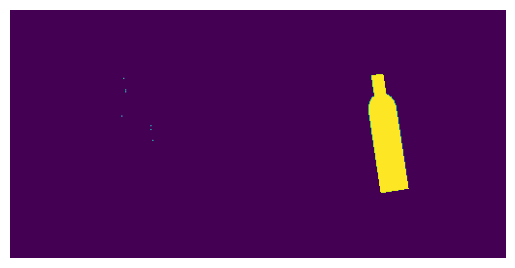

In [5]:
example_data = dataset[5]

plt.figure()
print(example_data['image'])
show_datapair(example_data['image'], example_data['label'])
plt.show()

## Choose Hyperparamters

Look into the file neural_nets.trainer to see which hyperparameters you can choose.
The seperation into tunable and non tunable hyperparameters is made, because this makes parameter searches with ray easier.


#### Non Tunable Hyperparameters


In [6]:
from neural_nets.trainer import NonTHparams


nt_h = NonTHparams()
nt_h.num_epochs = 50
nt_h.train_prop = 0.93 # set way to high to make validation period short and make testing this search easier

nt_h.print_log = True # to better see param search results
nt_h.log_train_period = 100
nt_h.log_val_freq = 5 #int(nt_h.train_prop*len(dataset)/f)-1 #set low to test this parameter search


#### Define Tunable Hyperparameters and parameter spaces for upgrade

The hyperparameters we want to tone have to be put into a list of possible values and that list into a dict, for the hyperparameter optimizer to do its job.

In [7]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

from neural_nets.trainer import THparams
from neural_nets.weight_inits import weight_init_kx
from neural_nets.models.unet import UNet2


from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

t_h = THparams()
t_h.batch_size = 16

t_h.model = UNet2
t_h.weight_init = weight_init_kx
t_h.depth = 5
t_h.channels = 64

t_h.lr = 1e-4
t_h.optimizer = optim.Adam
t_h.loss_func = nn.BCELoss()


image_resolution = dataset[0]['image'].shape[1]
max_unet_depth = int(np.log2(image_resolution))

# config is the set of params, that will be searched, they got to ghave the same key names, as variables in THparams
config = {
    "batch_size": tune.choice([2 ** i for i in range(2,5)]),
    "lr": tune.loguniform(1e-7, 1e-2),
    "depth": tune.choice([i for i in range(3,max_unet_depth+1-2)]),
    "channels": tune.choice([2 ** i for i in range(4,9)])
}




## Initialize Trainer

In [8]:
from neural_nets.trainer import Trainer

trainer = Trainer(nt_h, t_h, dataset)



During training, progress will be logged to tensorboard. Go to project folder, activate appropritae conda environment and run 'tensorboard --logdir runs/' to see the logs.


## Run Parameter Search

In [9]:
import ray
import GPUtil



os.environ["RAY_CHDIR_TO_TRIAL_DIR"] = "0" # needed so that we still can load files using path relative to working directory, 
                                           # as these fuckers change it 
ray.shutdown()
context = ray.init(num_cpus=10)
print("Ray dashboard URL: ", context.dashboard_url)

def tune_func(config):
        tune.utils.wait_for_gpu(target_util=0.2)
        trainer.train_from_dict(config)
    


2024-06-23 15:42:47,188	INFO worker.py:1761 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Ray dashboard URL:  127.0.0.1:8265


### Early Stopping, ASHAScheduler

In [10]:

if False:
    num_samples=40
    max_num_epochs=4*nt_h.log_val_freq # it is not num epochs, but how often we calculae val loss (we can also calc it mid epoch) todo: make it more logical
    gpus_per_trial = 1
    
    scheduler = ASHAScheduler(
            metric="loss",
            mode="min",
            max_t=max_num_epochs,
            grace_period=1,
            reduction_factor=2,
        )
    
    def tune_func(config):
        tune.utils.wait_for_gpu(target_util=0.2)
        trainer.train_from_dict(config)
    
    result = tune.run(
            tune_func,
            resources_per_trial={"cpu": 10, "gpu": gpus_per_trial},
            config=config,
            num_samples=num_samples,
            scheduler=scheduler,
    
            raise_on_failed_trial=False,
        )
    



### BOHB (Bayesian Optimization HyperBand)

In [12]:
if True:
    from ray.tune.schedulers import HyperBandForBOHB
    from ray.tune.search.bohb import TuneBOHB
    
    
    num_samples=100
    max_num_epochs=10*nt_h.log_val_freq # it is not num epochs, but how often we calculae val loss (we can also calc it mid epoch) todo: make it more logical
    gpus_per_trial = 1
        
    
    search_alg = TuneBOHB()
    scheduler = HyperBandForBOHB(
                metric="loss",
                mode="min",
                max_t=max_num_epochs, # Maximum number of iterations
                reduction_factor=2, # Reduce trials by a factor of 2 at each stage
    )


    result = tune.run(
        tune_func,
        config=config,
        search_alg=search_alg,
        scheduler=scheduler,
        num_samples=num_samples,  # Typically requires more samples to be effective
        raise_on_failed_trial=False,
        resources_per_trial={"cpu": 10, "gpu": gpus_per_trial},
    
    )
    




    
    

2024-06-23 15:47:31,791	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


RuntimeError: Trying to sample a configuration from TuneBOHB, but the `metric` (None) or `mode` (None) parameters have not been set. Either pass these arguments when instantiating the search algorithm, or pass them to `tune.TuneConfig()`.

### Print Result

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")